**Crecimiento de la Inteligencia Artificial en la Ciencias Biológicas (2000-2025): Búsquedas semiautomatizadas en PubMed**

Instalación de bibliotecas

In [ ]:
!pip install biopython pandas wordcloud matplotlib numpy seaborn

Agrega los requisitos necesarios para conectarse a la base de datos de NCBI, para comenzar con el análisis semántico y la generación de gráficas

In [2]:
from Bio import Entrez
import pandas as pd
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import re

**Definición los términos de búsqueda**

Escribe tu email para usar la API de PubMed. Crea dos listas con los términos de búsqueda de la IA y los campos de búsqueda. Agrupalos en un diccionario para facilitar su búsqueda

In [ ]:
Entrez.email = "youremail@example.com"

ai_field = ["Artificial Intelligence", "Machine learning", "Deep learning"]
biofield = ["Biology", "Biomedicine", "Bioinformatics", "Genetics", "Ecology"]

dict_terms = {}
for i in biofield:
    dict_terms[i] = ai_field

print(dict_terms)

**Función 1. Estrategia de búsqueda**

Se toman dos términos siendo uno de biología y otro de IA, los cuales se buscan en los artículos de PubMed, donde contegan ambos términos. Estos se limitan a un rango de 500 artículos encontrados entre 2000-2025. Los resultados obtenidos se regresan en una lista de PMIDs.


Recursos:

(1) Dennstädt et al. 2024

(2) Stack Overflow (2023)

In [4]:
#Realiza búsquedas en PubMed por combinación de términos de IA +  biología encontrados en el título y resumen
def pubmed_data(terms, start_year="2000", end_year="2025", max_res=500):
  sugg = f""""{terms[0]}"[Title/Abstract] AND "{terms[1]}"[Title/Abstract] AND ({start_year}:{end_year}[dp])"""
  handle = Entrez.esearch(db="pubmed", term=sugg, retmax=max_res)
  results = Entrez.read(handle)
  handle.close()
  return results.get("IdList",[])

**Función 2. Minería de texto**

Por medio del módulo 'Entrez.efetch' es posible obtener los registros completos de cada documento de la lista de PMIDs. Se obtiene un dataframe donde se agregaron los metadatos solicitados.


Recurso:

(3) TLDWTutorials. (2024)

In [5]:
def details_rec(id_list, ai_term, bio_term):
    df = pd.DataFrame(columns=['PMID', 'Title', 'Abstract', 'Year', 'MeSH_Keywords', 'URL', 'Term_List','Bio_Term'])

     #Complete XML
        #print(json.dumps(docs, indent=4, default=str))

    for pmid in id_list:
        try:
            handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
            docs = Entrez.read(handle)
            handle.close()

            for doc in docs['PubmedArticle']:
                paper = doc['MedlineCitation']['Article']

                title = paper['ArticleTitle']
                abstract = ' '.join(paper['Abstract']['AbstractText']) if 'Abstract' in paper and 'AbstractText' in paper['Abstract'] else 'Abstract not available'
                year = paper['Journal']['JournalIssue']['PubDate'].get('Year', 'No year found')
                #Palabras clave MeSH
                keywords = ', '.join(keyword['DescriptorName'] for keyword in doc['MedlineCitation'].get ('MeshHeadingList', [])) or 'Keyword not found'

                url = f"https://www.ncbi.nlm.nih.gov/pubmed/{pmid}"

                pubmed_df=pd.DataFrame({
                    'PMID':[pmid],
                    'Title':[title],
                    'Abstract':[abstract],
                    'Year':[year],
                    'MeSH_Keywords': [keywords],
                    'URL': [url],
                    'Term_List': [ai_term],
                    'Bio_Term':[bio_term]})

                df = pd.concat([df,pubmed_df], ignore_index=True)

        except Exception as e:
            print(f"PMID error {pmid}: {e}")
            continue

        time.sleep(2)

    return df


**Procesamiento de los datos**

Se itera cada combinación de los términos de IA y campo de la biología. Se extraen los metadatos de cada artículo y se almacenan en dataframes separados, que posteriormente son concatenados a un dataframe único  


Recursos:

(4) Stack Overflow. (2015)

In [ ]:
all_results_df = []
for bioterm, termlist in dict_terms.items():
  for ai_term in termlist:
    id_list = pubmed_data([bioterm, ai_term], start_year="2000", end_year="2025")
    time.sleep(2)
    df_result = details_rec(id_list, ai_term, bioterm)
    all_results_df.append(df_result)

if all_results_df:
    #Se verifica si hay resultados existentes. Si los hay, se agregan al nuevo dataframe
    df_final = pd.concat(all_results_df, ignore_index=True)
    print(df_final)

    #Este paso es para revisar el número total de PMIDs encontrados de todas las combinaciones
    pmid_count = len(df_final)

else:
    pmid_count=0
    print("No results found")
print(f"\nPMID found: {pmid_count}")

**Duplicados**

Se eliminan los PMID duplicados de 'df_final'

In [9]:
df_clean = df_final.drop_duplicates(subset=['PMID'])

**Agrupar palabras clave**

Se crea la columna 'text_paper', donde combina las palabras clave encontradas en [Title/abstact].
Las listas son generadas para almacenar las palabras clave de MeSH y [Title/abstract].
Se agregan las 'STOPWORDS', filtrando signos de puntuación y partes semánticas no significativas, además se muestran en minúsculas.

Recursos:

(5) Stack Overflow. (2012)

(6) W3Schools. (s.f.)

(7) Python Software Foundation. (s.f.)

(8) Kricka et al. (2021)

(2) Dennstädt et al. (2024)

(9) Stack Overflow (2020)

In [89]:
#Se crea una nueva columna en el dF "df_clean" y se combinan los campos de títulos y resumen de los artículos
df_clean['text_paper'] = df_clean['Title'] + ' ' + df_clean['Abstract']

#Lista vacía para palabras clave de MeSH
mesh_kw = []
for keywords in df_clean['MeSH_Keywords']:
  if keywords != 'Keyword not found':
    words = [word.strip().lower() for word in keywords.split(',')]
    mesh_kw.extend(words)

stopwords=(["4", "two", "2","mi", "mrow","many", "3", "may", "best", "one", "well", "three", "will", "0", "1", "S","s","large","foundanimal", "founddeep","synthetickeyword","processingkeyword","learningkeyword", "personnelkeyword","foundkeyword","intelligencekeyword","proliferationkeyword", "foundhumans", "available", "keywords", "found","no", "not", "keyword"]) + list(STOPWORDS)

##Lista vacía para almacenar las palabras clave de Títle/Abstract "TiAB"
TiAb_kw = []
for text_p in df_clean['text_paper']:
  #Las palabras que se obtengan estarán en minúsculas y se eliminarán signos de puntuación
  text_p = text_p.lower()
  text_p = re.sub(r'[^\w\s]', ' ', text_p)
  words = text_p.split()
  words = [word for word in words if word and word not in stopwords]
  TiAb_kw.extend(words)

# Se combinan ambas listas de palabras clave
all_kwlist = mesh_kw +  TiAb_kw

**Conteo de frcuencia de palabras clave**

Mediante el módulo 'Counter' de la biblioteca 'Collections', las palabras clave más comúnes dentro del conteo son analizadas

Recurso:

(10) GeeksforGeeks. (2025)

In [90]:
#Se contean las palabras claves existentes en "all_kwlist"
kw_counter = Counter(all_kwlist)

#De todas las palabras clave, se tomarán sólo 77 palabras que más se repiten
frequent_kw = kw_counter.most_common(77)
print("\nFrequent keywords:")
for keyword, frequency in frequent_kw:
  print(f"{keyword}: {frequency}")


Frequent keywords:
learning: 7184
data: 6406
based: 4211
analysis: 4031
machine: 4022
model: 3733
models: 3525
using: 3525
genes: 3067
deep: 2957
study: 2713
cell: 2668
methods: 2665
research: 2650
protein: 2620
ai: 2619
potential: 2509
disease: 2385
prediction: 2301
gene: 2297
cancer: 2265
artificial: 2189
genetic: 2157
clinical: 2141
intelligence: 2095
high: 2071
humans: 2055
used: 1936
molecular: 1830
development: 1722
biology: 1689
expression: 1681
related: 1665
network: 1651
drug: 1617
new: 1609
algorithms: 1586
approaches: 1586
accuracy: 1564
including: 1561
biomarkers: 1543
approach: 1528
bioinformatics: 1504
results: 1498
review: 1475
identified: 1472
associated: 1446
patients: 1430
human: 1417
immune: 1413
risk: 1378
biological: 1374
performance: 1363
novel: 1331
studies: 1322
treatment: 1313
information: 1295
features: 1284
identify: 1280
applications: 1279
key: 1273
datasets: 1271
cells: 1240
use: 1238
significant: 1219
computational: 1201
understanding: 1174
genetics: 1166

**Gráfico 1**

La gráfica de barras contiene 15 de las palabras clave más frecuentes en MeSH y [Title/Abstract]

Recursos:

(11) Stack Overflow. (2022)

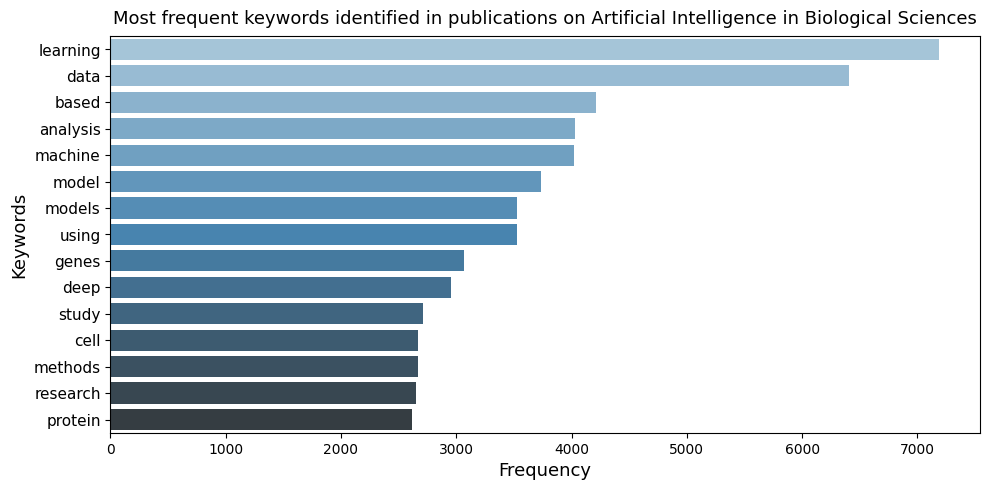

In [91]:
plt.figure(figsize=(10, 5))
#Se seleccionan 15 palabras más frecuentes para poderlas graficar junto con su frecuencia
keywords = [keyword for keyword, _ in frequent_kw[:15]]
frequencies = [frequency for _, frequency in frequent_kw[:15]]

sns.barplot(x=frequencies, y=keywords, palette='Blues_d', hue=keywords, legend=False)

plt.title('Most frequent keywords identified in publications on Artificial Intelligence in Biological Sciences', fontsize=13, y=1.01)
plt.xlabel('Frequency', fontsize=13)
plt.xticks(fontsize=10)
plt.ylabel('Keywords', fontsize=13)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig('common_keywords.png', dpi=300)

plt.show()

**Crear un diccionario para las palabras clave**

La biblioteca de WordCloud no puede interpretar la estructura de tuplas de 'frequent_kw', por lo que se crea el diccionario donde se almacene la información como clave-valor


In [92]:
kw_dict = dict(frequent_kw)

**Gráfico 2. Generar la nube de palabras**

Por medio de '.generate_from_frequencies()' , el diccionario de palabras clave se agrega, de esta manera se puede conocer la frecuencia de las palabras visualmente.

Recursos:

(12)  Mueller. (2020)

(13) Mueller. (2020)

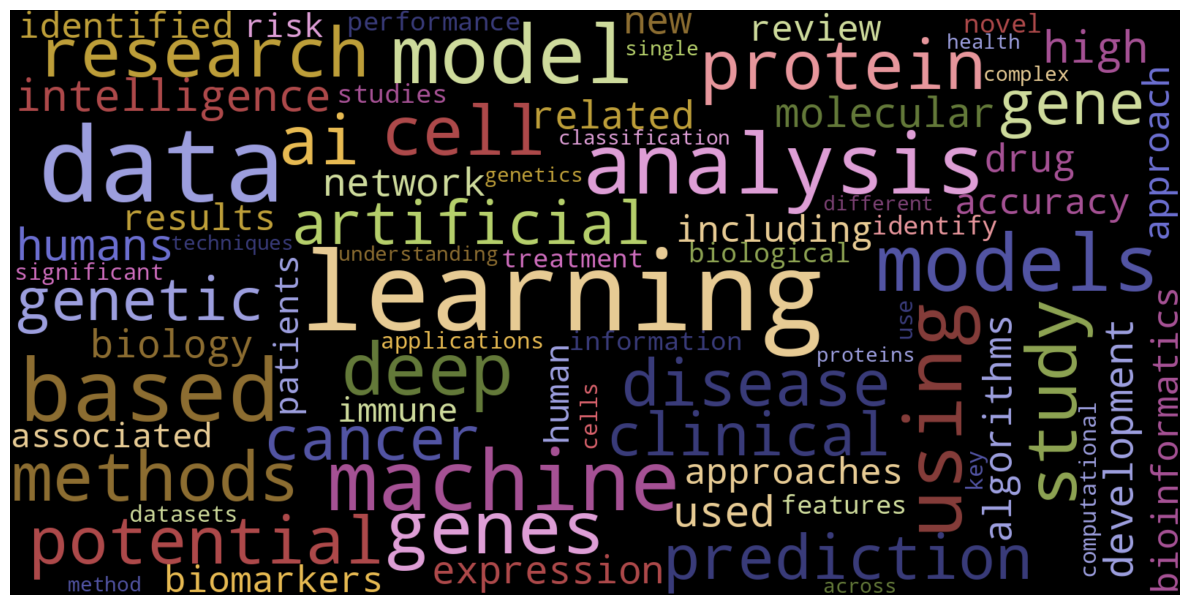

In [94]:
wordcloud_freq = WordCloud(max_words=100, stopwords=stopwords, width=1600, height=800, background_color="black", max_font_size=150).generate_from_frequencies(kw_dict)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_freq.recolor(colormap='tab20b'),interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1.08)
plt.savefig('wordcloud_freq.png', dpi=300)
plt.show()

**Conversión de datos**

Esta parte es importante para convertir la columna de 'Years' en string a numérico, de esta manera se podrá gráficar mediante la ditribución de las publicaciones a través de los años. Además los términos de la IA son cambiados a string.

Recursos:

(14) Stack Overflow. (2020)

(15) GeeksforGeeks. (2024)

In [95]:
#La columna de "Year" se convierte a númerico para posteriormente sean filtrados entre 2000 y 2025
df_clean['Year']=pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2025)]

#Este paso es para examinar la distribución de los artículos por año
year_distribution=df_clean.groupby(["Year"]).size()
print("Distribution:")
print(year_distribution)

#En un nuevo dataframe donde agrupan los datos como los términos de búsqueda de la IA y de biología. Y se cuentan cuántos términos existen.
df_clean['Term_List']=df_clean['Term_List'].astype(str)
df_bar = df_clean.groupby(['Bio_Term', 'Term_List']).size().reset_index(name='Count')

print(df_clean)

Distribution:
Year
2004.0       3
2006.0       3
2007.0       3
2008.0       3
2009.0       6
2010.0       5
2011.0       5
2012.0       2
2013.0       5
2014.0       7
2015.0      16
2016.0      24
2017.0      27
2018.0      55
2019.0     101
2020.0     137
2021.0     244
2022.0     414
2023.0     682
2024.0    1313
2025.0    1650
dtype: int64
          PMID                                              Title  \
0     40521196  Extrachromosomal circular DNA drives dynamic g...   
1     40516836  Bridging biomedicine and technology: the impac...   
2     40511682  Artificial intelligence approaches for tumor p...   
3     40510168  Unlocking the potential of flavonoid biosynthe...   
4     40507825  Liquid Biopsy: The Challenges of a Revolutiona...   
...        ...                                                ...   
4702  33466513  Mask R-CNN and OBIA Fusion Improves the Segmen...   
4703  32620873  A new method to control error rates in automat...   
4704  31970895  Neural hierarchi

**Gráfico 3. Conteo de publicaciones de la IA y los campos biológicos**

Desde 'df_bar', se crea una gráfica que muestra el total de publicaciones encontradas en cada combinación de los términos de búsqueda entre la IA y los campos de la biología establecidos.

Recursos:

(16) Python Graph Gallery. (2024)

(17) Laiq, F. (2024)

(18) Modin Project. (2019)

(19) Mulina, V. (2023)

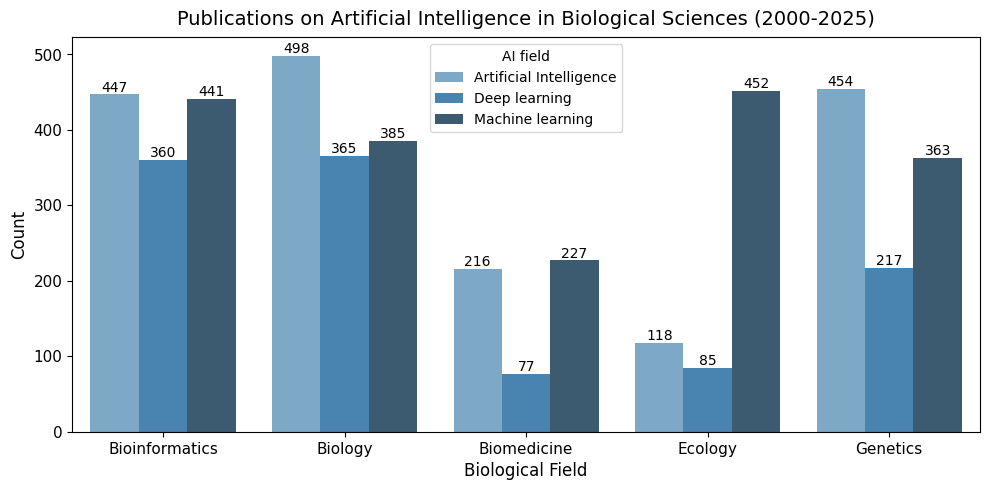

In [96]:
plt.figure(figsize=(10, 5))
#Para la gráfica de barras, en el eje "x", se agregan los campos biológicos y en el eje "y", se agrega el conteo.
ax=sns.barplot(x='Bio_Term', y='Count', hue='Term_List', data=df_bar, palette='Blues_d')

plt.title('Publications on Artificial Intelligence in Biological Sciences (2000-2025)', fontsize=14, y= 1.01)
plt.xlabel('Biological Field', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='AI field', fontsize=10)


#Se anotan los valores a cada una de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.savefig('barplot_count.png', dpi=300)
plt.show()

**Gráfico 4. Menciones totales de la IA en las ciencias biológicas**

Se identifica el uso de la IA en los campos de la biología a lo largo del tiempo

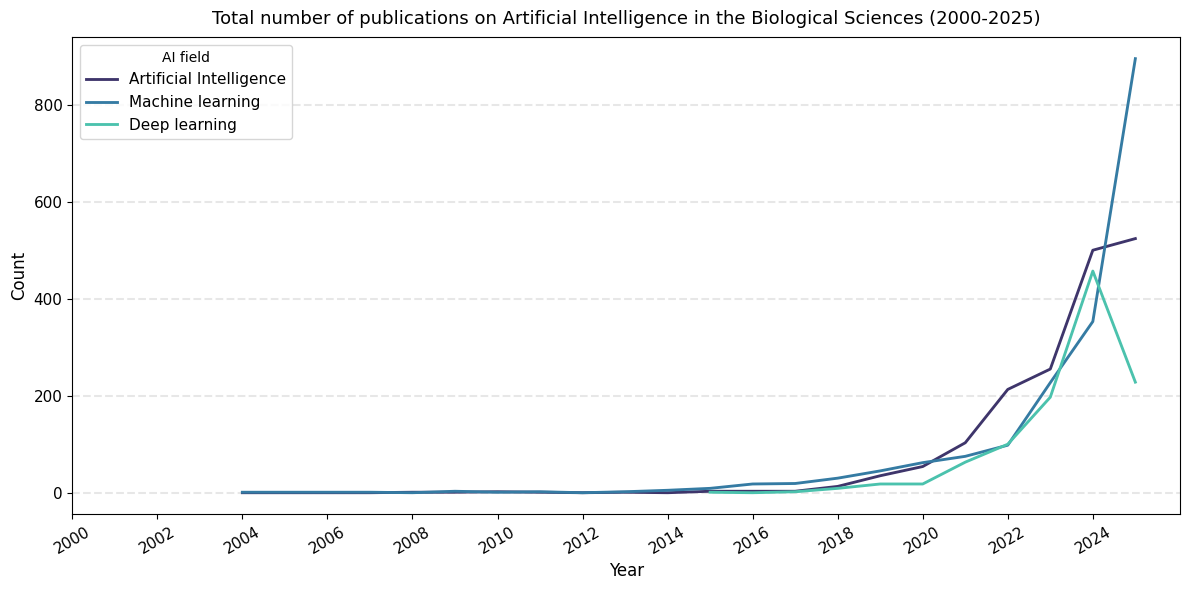

In [99]:
#Agrupa los datos por año y tipo de IA, contando cuantas filas hay en cada grupo
summary_df = df_clean.groupby(['Year', 'Term_List']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Count', hue='Term_List', data=summary_df, linewidth=2.05, palette='mako')

plt.title("Total number of publications on Artificial Intelligence in the Biological Sciences (2000-2025)", fontsize=13, y= 1.01)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(2000,2026, 2), rotation=30, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=1.5, axis='y')

plt.legend(title='AI field', fontsize=11)

plt.tight_layout()
plt.savefig("total_pub", dpi=300)
plt.show()

Referencias

(1) Dennstädt, F., Zink, J., Putora, P. M., Hastings, J., & Cihoric, N. (2024). Title and abstract screening for literature reviews using large language models: an exploratory study in the biomedical domain. Systematic Reviews, 13(1). https://doi.org/10.1186/s13643-024-02575-4

(2) Stack Overflow (2023). *Biopython: How can I increase the number found using Entrez.esearch?* https://stackoverflow.com/questions/75933779/biopython-how-can-i-increase-the-number-of-articles-found-using-entrez-esearch

(3) TLDWTutorials. (2024). PubMed Data Extraction Script. GitHub. https://github.com/TLDWTutorials/PubmedAPI/tree/main

(4) Stack Overflow. *Appending pandas dataframes generated in a for loop*. (2015). https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

(5) Stack Overflow. (2012). *String concatenation of two pandas columns*. https://stackoverflow.com/questions/11858472/string-concatenation-of-two-pandas-columns

(6)W3Schools. (s.f.). *Python RegEx*. https://www.w3schools.com/python/python_regex.asp

(7) Python Software Foundation. (s.f.). *re-Regular expression operations*. Recuperado el 22 de abril  de 2025. https://docs.python.org/3/library/re.html

(8) Kricka, L. J., Cornish, T. C., & Park, J. Y. (2021). Eponyms in clinical chemistry. Clinica Chimica Acta, 512, 28–32. https://doi.org/10.1016/j.cca.2020.11.014

(9) Stack Overflow (2020). *How to fund specific words in a text and count them using Python?. https://stackoverflow.com/questions/63666138/how-to-find-specific-words-in-a-text-and-count-them-using-python

(10) GeeksforGeeks. (2025). *Python most_common() Function*. https://www.geeksforgeeks.org/python-most_common-function/

(11) Stack Overflow. (2022). *Unpack the first two elements in list/tuple*. https://stackoverflow.com/questions/11371204/unpack-the-first-two-elements-in-list-tuple

(12)  Mueller. (2020). *wordcloud.WordCoud*. https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

(13) Mueller. (2020). *Using frequency*. https://amueller.github.io/word_cloud/auto_examples/frequency.html

(14) Stack Overflow. (2020). *How do I transform a pandas groupby with a condition on the transformation?*. https://stackoverflow.com/questions/61815267/how-do-i-transform-a-pandas-groupby-with-a-condition-on-the-transformation

(15) GeeksforGeeks. (2024). *Pandas dataframe.groupby() Method*. https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/

(16) Python Graph Gallery. (2024). *Basic Barplot using Seaborn*. https://python-graph-gallery.com/basic-barplot-with-seaborn/

(17) Laiq, F. (2024). *Filtrar filas que contienen una cadena específica en Pandas*. https://www.delftstack.com/es/howto/python-pandas/pandas-column-contains-string/?utm_source=chatgpt.com

(18) Modin Project. (2019).*Issue #847. Plotting with seaborn*. https://github.com/modin-project/modin/issues/847

(19) Mulina, V. (2023). *Bank Customers Categorization - Clustering*. https://www.kaggle.com/code/valeriamulina/bank-customers-categorization-clustering?scriptVersionId=139180478
